# Google colab setup

In [ ]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/pxydi/amld20_text_classification.git
        
    # Copy files required to run the code
    !cp -r "amld20_text_classification/data" "amld20_text_classification/tools.py" .
    
    # Install packages via pip
    !pip install -r "amld20_text_classification/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Text preprocessing

Text is highly unstructured and needs to be prepared into a form that can be processed by machine learning algorithms. There are several different [approaches](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for extracting features from text and we will explore a few of them in the next notebook. However, before extracting features from text, we need to "preprocess" it, i.e., "clean" and "standardize" it. This is because raw text can be "messy", especially when coming from social media platforms! We need to keep as many "informative" words as possible while discarding the "uninformative" ones. Removing unnecessary terms, i.e., the "noise", will improve our models' performance.

We will be using the [Sentiment140](http://help.sentiment140.com/for-students/) public twitter corpus. This dataset contains ~500 tweets, labeled as positive, negative, or neutral. The dataset is available in the *data* folder.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, random, string
from collections import defaultdict

# Gensim
import gensim
from gensim.models import Phrases


# Load helper functions
import tools

In [2]:
# Load corpus (twitter dataset)

path = os.path.join('data','sentiment_140.csv')
df   = pd.read_csv(path, header=None)

# Rename columns
df.columns = ['label','tweet']

# Re-order columns
df = df[['tweet','label']].copy()

# Drop duplicates
df = df.drop_duplicates('tweet')

# Remove empty rows
df = df.dropna()

# Rename labels
label_dict = {0:'neg', 2:'neutral', 4:'pos'}
df['label'] = df['label'].replace(label_dict)

# Reset index
df.reset_index(inplace=True,drop=True)
print('Data size: ',df.shape)

Data size:  (498, 2)


**Take a few minutes to look at the raw text. What do you think we should remove from the text?**

In [3]:
df.sample(5)

,tweet,label
187,Is Eating and Watching Movies....,neutral
327,Will the Lakers kick the Nuggets ass tonight?,pos
286,"F*** up big, or go home - AIG",neg
422,"HATE safeway select green tea icecream! bought two cartons, what a waste of money. &gt;_&lt;",neg
405,My dentist appt today was actually quite enjoyable.,pos


There are many different ways for text preprocessing, depending on the application and the text's language. Below are a few suggestions of what we could address in this particular dataset. However, keep in mind that you may have to adapt the techniques discussed in this notebook to your specific case.

* remove URLs (e.g., http://bit.ly/19epAH, www.tinyurl.com/m595fk)
* remove RT (stands for retweet)
* remove Twitter usernames (e.g., @BlondeBroad)
* remove hashtags (e.g. #Adidas -> Adidas)
* remove punctuation. However, a few groupings, such as `:-), <3, : d`, etc., express emotion, so, depending on the task, we may want to keep them in the text.
* remove numbers (e.g. 2020, 2, 15, ...)
* perform case conversion (e.g. Good -> good, ...)
* remove stopwords
* remove non-ASCII characters
* standardize the number of repeated characters, e.g. ("I loooooooovvvvvveee" -> "I loovvee")
* expand contractions (e.g. "don't" -> "do not", "won't" -> "will not", ...)
* apply stemming
* ...

### Tokenization

Tokenization is the process of splitting text into **words**.

Example:

$$\text{I came to Bern by train.} -> \text{[I, came, to, Bern, by, train.]}$$
  
  
**The *TweetTokenizer***

The *TweetTokenizer* is a nice tool from the NLTK library, specially designed for tokenizing tweets. Apart from spliting text into words, it offers a few additional key options:
- reduces the number of repeated characters within a token e.g. "everrrrr" -> "everrr" (use: *reduce_len=True*)
- removes Twitter usernames (use: *strip_handles=True*)
- preserves punctuation and emoticons.

Let's see this with a few examples ([source](https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer)).

In [4]:
# Import tokenizer
from nltk.tokenize import TweetTokenizer

# Create an instance  of the tokenizer
tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)

In [5]:
# Example using emoticons and punctuation

sample_1 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"

print(sample_1,'\n')
print(tokenizer.tokenize(sample_1))

This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <-- 

['This', 'is', 'a', 'coool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']


In [6]:
# Example using strip_handles and reduce_len parameters

sample_2 = '@remy: This is waaaaayyyy too much for you!!!!!!'

print(sample_2,'\n')
print(tokenizer.tokenize(sample_2))

@remy: This is waaaaayyyy too much for you!!!!!! 

[':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']


### Case folding

We usually convert all documents to lowercase. This is because we want our models to count e.g. "I" together with "i", "The" together with "the", etc.

In [7]:
sample_3 = "I don't like this movie!"

print('Original tweet: \t\t\t{}\n'.format(sample_3))

# Case folding
print('Convert to lowercase: \t\t\t{}\n'.format(sample_3.lower()))

Original tweet: 			I don't like this movie!

Convert to lowercase: 			i don't like this movie!



### Stopwords

Stopwords are words that are essential for a sentence to make sense, such as: "I", "the", "and", etc. The issue with stopwords is that they are: *very frequent* and *uninformative*. For most NLP applications, it is a good idea to remove them from text. 

Most NLP libraries provide pre-compiled lists of stopwords for several languages. In this notebook, we will use the list provided by the [NLTK library](https://www.nltk.org/). 

In [8]:
# Load english stopwords from nltk

from nltk.corpus import stopwords          
stopwords_english = stopwords.words('english') 

In [9]:
# Print stopwords

print('{} stopwords in NLTK\'s list.\n'.format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

Interestingly, the NLTK stopword list includes negation words such as:

- no, nor, not
- don't, didn't, wouldn't


In [10]:
# Check if 'not' is in stopwords_english

'not' in stopwords_english

True

In [11]:
# Check if "don't" is in stopwords_english

"don't" in stopwords_english

True

This may be an important point to keep in mind, depending on the application. For example, if we use the NLTK stopword list "out-of-the-box", then a sentence like: "I don't like this movie" will become: "like this movie". We see that the processed sentence conveys the exact opposite sentiment from the original one! 

**We need to be aware of the limitations of pre-compiled stopwords lists; making sure that we adapt them to our particular needs may be necessary for some specific tasks (e.g. sentiment analysis, product reviews, etc.).**

We will "customize" the NLTK stopword list to ensure that we don't remove negation words from tweets.

In [12]:
# Remove negation words from nltk's stopword list

not_stopwords = {'no', 'nor', 'not'} 
custom_stopwords = set([word for word in stopwords_english if word not in not_stopwords])

In [13]:
# Check if 'not' is in custom_stopwords

'not' in custom_stopwords

False

### Contractions

In practice, customizing the NLTK stopword lists will not be enough for preserving negation words in the text. We should also expand contractions: e.g. "don't" -> "do not". We can do this with the library "expand_contractions".

In [14]:
#!pip install contractions
import contractions

sample_3 = "I don't like this movie!"
print('Original tweet: \t\t\t{}\n'.format(sample_3))

# Case folding
print('Convert to lowercase: \t\t\t{}\n'.format(sample_3.lower()))

# Expand contractions
sample_3_expanded = contractions.fix(sample_3.lower())
print('Expand contractions: \t\t\t{}\n'.format(sample_3_expanded))

# Tokenize tweet
print('Tokenize: \t\t\t\t{}\n'.format(sample_3_expanded.split()))

# Remove stopwords
print('Remove stopwords: \t\t\t{}\n'.format([w for w in sample_3_expanded.split() if w not in custom_stopwords]))

Original tweet: 			I don't like this movie!

Convert to lowercase: 			i don't like this movie!

Expand contractions: 			i do not like this movie!

Tokenize: 				['i', 'do', 'not', 'like', 'this', 'movie!']

Remove stopwords: 			['not', 'like', 'movie!']



We made sure that the "important" words for guessing the sentiment of this tweet (i.e. "not" and "like") were preserved!

### Stemming

Another part of text normalization is stemming, in which we mainly strip suffixes from the end of the word. The Porter stemmer is a widely used stemming tool for the English language. Stemming helps to connect words and reduce the size of the vocabulary (i.e., the number of unique words in a corpus). However, it can produce non-words, i.e., words that you won't find in a dictionary.

In [15]:
# Load stemmer

from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

In [16]:
# Stem of "retrieve"

stemmer.stem('retrieve')

'retriev'

In [17]:
# Stem of "retrieval"

stemmer.stem('retrieval')

'retriev'

In [18]:
# Stem of "retrieved"

stemmer.stem('retrieved')

'retriev'

### The process_tweet function

Now let's bring everything together and create the `process_tweet` funchion which takes a tweet as an argument and  preprocesses it.

In [19]:
# Create process_tweet function

def process_tweet(tweet):
    
    '''
    Preprocess raw samples of tweets.
    
    INPUT: 
    - tweet: raw text (string)
    
    OUTPUT:
    - processed_tweet: processed tweet (string)
    '''
    
    # Remove RT
    clean_tweet = re.sub(r'RT','',tweet)

    # Remove URL
    clean_tweet = re.sub(r'https?:\/\/[^\s]+','',clean_tweet)

    # Remove hash #
    clean_tweet = re.sub(r'#','',clean_tweet)

    # Remove numbers
    clean_tweet = re.sub(r'\d+','',clean_tweet)

    # Convert to lowercase
    clean_tweet = clean_tweet.lower()
    
    # Remove punctuation repetions (that are not removed by TweetTokenizer)
    clean_tweet = re.sub(r'([._]){2,}','',clean_tweet)
    
    # Remove non-ascii chars
    clean_tweet = ''.join([c for c in str(clean_tweet) if ord(c) < 128])

    # Expand contractions
    clean_tweet = contractions.fix(clean_tweet)
    
    # Tokenize tweet
    tokens = tokenizer.tokenize(clean_tweet)

    # Remove punctuation (except emoticons), stopwords, single-char words and apply stemming
    clean_tokens = [stemmer.stem(w) for w in tokens if (w not in string.punctuation) and
                       (w not in custom_stopwords) and (len(w)>1)]
    
    # The stemmer strips the final 's but leaves the apostroph: warner's -> warner'
    # Here, I'm removing the apostroph from the end of words
    clean_tokens = [tok if tok[-1] != "'" else tok[:-1] for tok in clean_tokens]

    # Join tokens in a single string to recreate the tweet
    processed_tweet = ' '.join([tok for tok in clean_tokens])
    processed_tweet = processed_tweet.strip()
       
    return processed_tweet

Let's test this function with a few examples.

In [20]:
# Sample a tweet randomly from the corpus

tweet =  df.iloc[random.randint(0,len(df)-1),0]

print('Before cleaning: \t{}\n'.format(tweet))
print('After cleaning: \t{}\n'.format(process_tweet(tweet)))


Before cleaning: 	RT @sportsguy33: New Time Warner slogan: "Time Warner, where we make you long for the days before cable."

After cleaning: 	new time warner slogan time warner make long day cabl



### Collocations

There is one last thing we can do before moving on to feature extraction.

We can look for combinations of words that frequently appear together, such as: "Night at the museum", "Star Trek", "last night", "San Francisco", "North Korea", etc, and replace them by a unique token. 

Example: 

$$\text{"Star Trek" -> "Star_Trek"}$$
$$\text{"San Francisco" -> "San_Francisco"}$$
$$\text{"last night" -> "last_night"}$$


We often call these *phrases* or *collocations*; they are word combinations that are more common in the corpus than the individual words themselves. (*Note: "that is" is not considered a collocation*).

We will use Gensim's `models.phrases` to detect phrases (collocations) in our corpus. "Phrases" will identify the most common collocations and join the constituent tokens into a single token, using the "_" glue character. 

*Documentation*
* Gensim's website: https://radimrehurek.com/gensim/models/phrases.html
* Mikolov, *et. al*: ["Distributed Representations of Words and Phrases and their Compositionality"](https://arxiv.org/pdf/1310.4546.pdf)

In [21]:
# Process all tweets (and add to list)

processed_tweets = [process_tweet(tweet).split() for tweet in df['tweet']]

# Detect collocations in corpus

for i in ['bigrams']:
    print('Computing collocations ({})...'.format(i))
    
    bigram = gensim.models.Phrases(processed_tweets,   # Expected format: list of tokenized documents
                                   min_count=3,        # Ignore all words and bigrams with total collected count lower than this value.
                                   delimiter=b'_')     # Glue character used to join collocation tokens

    bigram_model = gensim.models.phrases.Phraser(bigram)

    # Add detected collocations to corpus
    processed_tweets = [' '.join(bigram_model[processed_tweet]) for processed_tweet in processed_tweets]
    print('Done!')
    
# Add processed tweets to dataframe
df['processed_tweet'] = processed_tweets

Computing collocations (bigrams)...
Done!


In [22]:
# Remove  empty tweets
df = df[df['processed_tweet'].apply(len) != 0].copy()

# Reindex dataframe
df.reset_index(inplace=True,drop=True)

# Re-order columns
df = df[['tweet','processed_tweet','label']]

print('Data size: ',df.shape)

Data size:  (498, 3)


This is how the processed tweets look like: 

In [23]:
df.sample(5)

,tweet,processed_tweet,label
369,"So, Night at the Museum 2 was AWESOME! Much better than part 1. Next weekend we'll see Up.",night_museum awesom much better part next weekend see,pos
411,Check this video out -- David After Dentist http://bit.ly/47aW2,check video david dentist,neutral
254,Watching Lebron highlights. Damn that niggas good,watch lebron highlight damn nigga good,pos
21,lebron and zydrunas are such an awesome duo,lebron zydruna awesom duo,pos
185,"At safeway on elkhorn, they move like they're dead!",safeway elkhorn move like dead,neg


**Let's find out which collocations were detected in the corpus!**

In [24]:
# Small exercise : Practice how to count word occurencies

# Sort collocations by frequency of appearence

In [25]:
collocations_dict = defaultdict(int)

for tweet in df['processed_tweet']:
    for word in tweet.split():
        if '_' in word:
            collocations_dict[word] += 1
            
# Sort counts in descending order
collocations_dict = {k:v for k,v in sorted(collocations_dict.items(), 
                                         key=lambda item:item[1], reverse=True)}
            
print('Found: {} collocations in corpus\n'.format(len(list(collocations_dict.keys()))))

# Print collocations (and frequency)
collocations_dict

Found: 20 collocations in corpus



{'time_warner': 35,
 'night_museum': 15,
 'twitter_api': 12,
 'malcolm_gladwel': 10,
 'last_night': 9,
 'san_francisco': 9,
 'bobbi_flay': 8,
 'go_see': 7,
 'warren_buffet': 7,
 'north_korea': 6,
 'goodbi_silverstein': 6,
 'watch_night': 6,
 'star_trek': 5,
 'viral_market': 5,
 'see_night': 5,
 'danni_gokey': 4,
 'new_blog': 4,
 'east_palo': 4,
 'see_star': 3,
 'es_f': 1}

### Classify (manually) tweets into "semantic" categories

In a later notebook, we will see how to identify semantically similar tweets, i.e., discussing related topics or themes. 

For the purpose of this analysis, we need to add tweets into semantic categories manually, based on selected keywords.

For example, we will add any tweet mentioning movie-related terms (e.g. "watch_night", "star_treck", "movi", etc.) to the category: "movies". Tweets mentioning politics-related terms (e.g. "north_korea", "obama", "pelosi", "bush", "china", "india", "iran", etc.) will be added to "politics". Tweets mentionning sports-related terms (e.g. "lebron", "laker", "basebal", "basketbal", "fifa", "ncaa", "roger", "feder", etc.) will be added to "sports". And so on.

We will use the function `add_to_semantic_category` to manually classify into "semantic" categories.

In [26]:
# Call function add_to_semantic_category() 

df = tools.add_to_semantic_category(df)

In [27]:
# Show a few samples

df.sample(5)

,tweet,processed_tweet,label,semantic_category
432,"Eating dinner. Meat, chips, and risotto.",eat dinner meat chip risotto,neutral,food
59,omg. The commercials alone on ESPN are going to drive me nuts.,omg commerci alon espn go drive nut,neg,cable TV
409,i hate the dentist....who invented them anyways?,hate dentistwho invent anyway,neg,unlabeled
73,Back when I worked for Nike we had one fav word : JUST DO IT! :),back work nike one fav word :),pos,Nike
408,@kirstiealley I hate going to the dentist.. !!!,hate go dentist,neg,dentist


In [28]:
# Export data

df.to_csv('data/clean_sentiment_140.csv',index=False)

### Exercises for this afternoon

1. Find the most common words in positive, negative and neutral tweets. Plot them in a meaningful way. Tip: Use the processed tweets!
2. Select a few terms of interest that you would like to visualize. Count how many times each of these words appears in positive tweets and how many times in negative tweets. Then use a scatter plot to visualize your results (plot positive counts on x-axis and negative counts on y-axis).

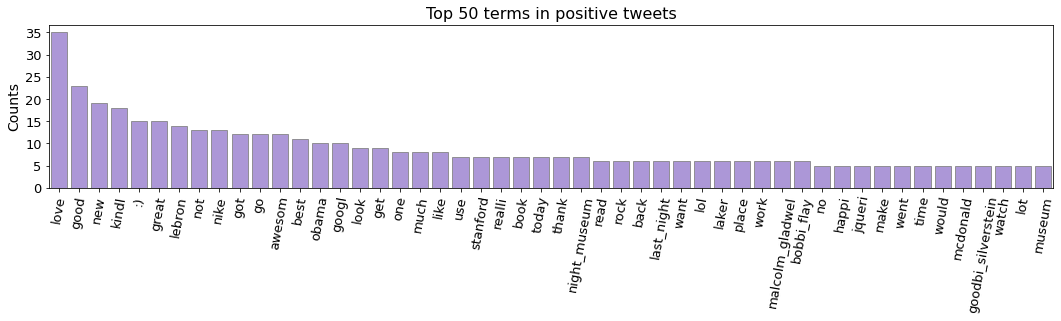

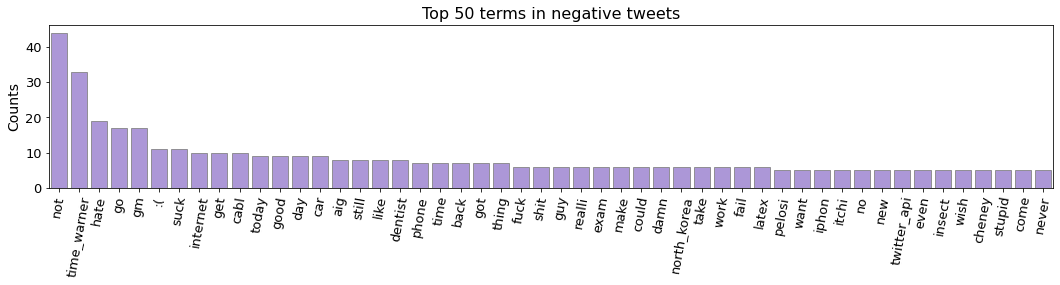

In [29]:
# Solution # 1

# Word frequencies

# Positive tweets
freq_pos = defaultdict(int)  # Defaultdict of type int: returns "zero" value of int if key doesn't exist

for tweet in df.loc[df['label'] == 'pos','processed_tweet'].values:
    for word in tweet.split():
        freq_pos[word] += 1

# Sort counts in descending order
freq_pos = defaultdict(int,{k:v for k,v in sorted(freq_pos.items(),
                                  key=lambda item:item[1], reverse=True)})

# Negative tweets
freq_neg = defaultdict(int)

for tweet in df.loc[df['label'] == 'neg','processed_tweet'].values:
    for word in tweet.split():
        freq_neg[word] += 1
        
# Sort counts in descending order
freq_neg = defaultdict(int,{k:v for k,v in sorted(freq_neg.items(),
                                  key=lambda item:item[1], reverse=True)})

# Plot most frequent words
tools.plot_most_frequent_terms(frequency_dict = freq_pos, terms_to_plot = 50, add_to_title='in positive tweets')
tools.plot_most_frequent_terms(frequency_dict = freq_neg, terms_to_plot = 50, add_to_title='in negative tweets')       

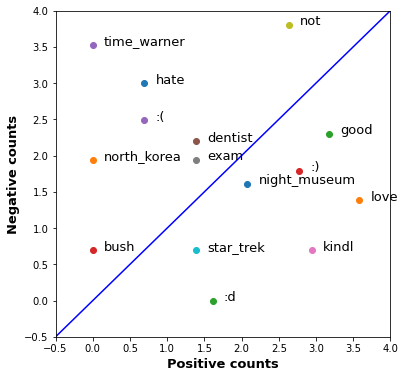

In [30]:
# Solution 2

selected_words =['hate','love','good',':)',':(','dentist','kindl',
                 'exam','not','star_trek','night_museum','north_korea',
                 ':d','bush','time_warner']

# Plot frequencies
plt.figure(figsize=(6,6))
for word in selected_words:
    plt.scatter(np.log1p(freq_pos[word]),np.log1p(freq_neg[word]))
    plt.annotate(word,(np.log1p(freq_pos[word])+0.15,np.log1p(freq_neg[word])),fontsize=13)

plt.plot([-2, 5], [-2, 5], color = 'blue') 
plt.xlabel('Positive counts',fontsize=13,weight='bold')
plt.ylabel('Negative counts',fontsize=13,weight='bold')
plt.xlim([-0.5,4])
plt.ylim([-0.5,4]);